# BillSum Predictions with PEGASUS

## Load Dependencies

In [ ]:
!pip uninstall -y flash-attn fsspec gcsfs transformers torch torchvision torchaudio
!pip install -q -U transformers accelerate bitsandbytes torch torchvision torchaudio datasets==2.14.6 fsspec==2023.9.2
!pip install -q -U rouge_score evaluate

Found existing installation: fsspec 2025.3.2
Uninstalling fsspec-2025.3.2:
  Successfully uninstalled fsspec-2025.3.2
Found existing installation: gcsfs 2025.3.2
Uninstalling gcsfs-2025.3.2:
  Successfully uninstalled gcsfs-2025.3.2
Found existing installation: transformers 4.53.2
Uninstalling transformers-4.53.2:
  Successfully uninstalled transformers-4.53.2
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 16.6 MB/s

In [ ]:
import datasets
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration, AutoConfig
import evaluate
from tqdm import tqdm
import torch
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns

## Load BillSum Dataset

In [ ]:
billsum_train = datasets.load_dataset("billsum", split = "train", streaming = True)
billsum_test = datasets.load_dataset("billsum", split = "test")

billsum_test

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['text', 'summary', 'title'],
    num_rows: 3269
})

### Check Max Sequence Length

PEGASUS has a maximum sequence length of 1028. We can tokenize a subset of the training data to check how many documents will be truncated.

In [ ]:
model_name = "google/pegasus-cnn_dailymail"

tokenizer = PegasusTokenizer.from_pretrained(model_name, from_pt=True)

In [ ]:
chunk_size = 1000
text_lengths = []
summary_lengths = []
for record in tqdm(islice(billsum_train, chunk_size), total = chunk_size):
  text_lengths.append(len(tokenizer(record["text"]).input_ids))
  summary_lengths.append(len(tokenizer(record["summary"]).input_ids))

100%|██████████| 1000/1000 [00:36<00:00, 27.27it/s]


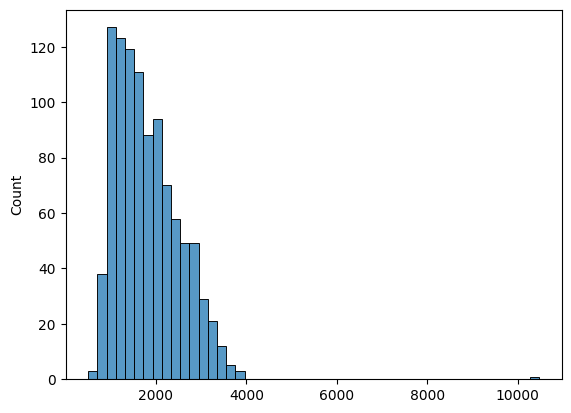

In [ ]:
sns.histplot(x = text_lengths)

plt.show()

## Load PEGASUS Model

In [ ]:
model = TFPegasusForConditionalGeneration.from_pretrained(model_name, from_pt=True)
config = AutoConfig.from_pretrained(model_name)

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFPegasusForConditionalGeneration.

Some weights or buffers of the TF 2.0 model TFPegasusForConditionalGeneration were not initialized from the PyTorch model and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_pegasus_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFPegasusMainLayer)  multiple                  570797056 
                                                                 
 final_logits_bias (BiasLay  multiple                  96103     
 er)                                                             
                                                                 
Total params: 570893159 (2.13 GB)
Trainable params: 570797056 (2.13 GB)
Non-trainable params: 96103 (375.40 KB)
_________________________________________________________________


## Test Base PEGASUS Without Fine Tuning

In [ ]:
def process_batch(batch):
  inputs = tokenizer(batch["text"], truncation = True, padding = "longest", return_tensors = "tf")
  return inputs, batch["summary"]

def generate_summaries(data, batch_size = 16):
  generated_summaries = []

  for i in tqdm(range(0, len(data), batch_size)):
    inputs, targets = process_batch(data[i:i+batch_size])

    output = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        early_stopping=True
    )

    generated_summaries += tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=False)

  return generated_summaries

In [ ]:
test_summaries_base = generate_summaries(billsum_test, 1)

  1%|          | 26/3269 [23:23<48:38:37, 54.00s/it]


KeyboardInterrupt: 